In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
import random
# set experiment consistency
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load data from the text file
with open('./data/IBM.txt', 'r') as file:
    lines = file.readlines()
    data = []
    dates = []

    for line in lines[1:]:
        parts = line.strip().split(',')
        date = parts[0]
        if '1980-12-12' <= date <= '2022-07-22':
            dates.append(date)
            data.append(float(parts[4]))  # 'Close' column

# Create a DataFrame from the loaded data
df = pd.DataFrame({'Date': pd.to_datetime(dates), 'Value': data})

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Extract the values from the DataFrame
signal = df['Value'].values
signal = signal.reshape(-1, 1)

# Define the training and testing data
train_size = int(len(signal) * 0.8)
train_data = signal[:train_size, :]
test_data = signal[train_size:, :]

# normalization
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

def create_groups(dataset, window_size_1, window_size_2, window_size_3, timeslice, step):
    X_data, y_data = [], []
    index = 0
    while index + (timeslice * window_size_3) < len(dataset):
        i = 0
        t1, t2, t3 = [], [], []

        # Populate t3
        while i < timeslice * window_size_3:
            current_slice = dataset[index + i:index + i + window_size_3, 0]
            if not np.isnan(current_slice).all():
                t3.append(np.mean(current_slice))
            i += window_size_3

        # Populate t2
        j = timeslice * window_size_3- timeslice * window_size_2
        while j < i:
            current_slice = dataset[index + j:index + j + window_size_2, 0]
            if not np.isnan(current_slice).all():
                t2.append(np.mean(current_slice))
            j += window_size_2

        # Populate t1
        j = timeslice * window_size_3 - timeslice * window_size_1
        while j < i:
            current_slice = dataset[index + j:index + j + window_size_1, 0]
            if not np.isnan(current_slice).all():
                t1.append(np.mean(current_slice))
            j += window_size_1
        t3=np.flip(t3)
        t2=np.flip(t2)
        t1=np.flip(t1)
        X_data.append([t1, t2, t3])
        y_data.append(dataset[index + timeslice * window_size_3])
        index += step

    return np.array(X_data), np.array(y_data)

window_size_1 = 1
window_size_2 = 3
window_size_3 = 9
timeslice = 4
step = 1
X_train, y_train = create_groups(train_data, window_size_1, window_size_2, window_size_3, timeslice, step)
X_test, y_test = create_groups(test_data, window_size_1, window_size_2, window_size_3, timeslice, step)

In [2]:
mock_data = np.arange(0, 100, 1).reshape(-1, 1)
X_train_mock, y_train_mock = create_groups(mock_data, window_size_1, window_size_2, window_size_3, timeslice, step)
X_train_mock[:5]

array([[[35., 34., 33., 32.],
        [34., 31., 28., 25.],
        [31., 22., 13.,  4.]],

       [[36., 35., 34., 33.],
        [35., 32., 29., 26.],
        [32., 23., 14.,  5.]],

       [[37., 36., 35., 34.],
        [36., 33., 30., 27.],
        [33., 24., 15.,  6.]],

       [[38., 37., 36., 35.],
        [37., 34., 31., 28.],
        [34., 25., 16.,  7.]],

       [[39., 38., 37., 36.],
        [38., 35., 32., 29.],
        [35., 26., 17.,  8.]]])

In [3]:
y_train_mock[:5]

array([[36],
       [37],
       [38],
       [39],
       [40]])

In [4]:
X_train_mock.shape, y_train_mock.shape

((64, 3, 4), (64, 1))

In [5]:
# Define the LSTM model architecture with 3 vrishables 4 features 64 neurons 3 layers 1 output
model = Sequential()
model.add(LSTM(16, input_shape=(3, 4), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with early stopping 
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
history = model.fit(X_train, y_train.squeeze(), epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

Epoch 1/200
262/262 [==============================] - 3s 4ms/step - loss: 0.0100 - val_loss: 3.1220e-04
Epoch 2/200
262/262 [==============================] - 1s 2ms/step - loss: 1.4399e-04 - val_loss: 2.5069e-04
Epoch 3/200
262/262 [==============================] - 1s 2ms/step - loss: 1.4056e-04 - val_loss: 2.6560e-04
Epoch 4/200
262/262 [==============================] - 1s 2ms/step - loss: 1.3844e-04 - val_loss: 2.9225e-04
Epoch 5/200
262/262 [==============================] - 1s 2ms/step - loss: 1.2693e-04 - val_loss: 2.5054e-04
Epoch 6/200
262/262 [==============================] - 1s 2ms/step - loss: 1.1827e-04 - val_loss: 2.0972e-04
Epoch 7/200
262/262 [==============================] - 1s 2ms/step - loss: 1.1927e-04 - val_loss: 2.0060e-04
Epoch 8/200
262/262 [==============================] - 1s 2ms/step - loss: 1.1001e-04 - val_loss: 2.7897e-04
Epoch 9/200
262/262 [==============================] - 1s 2ms/step - loss: 9.6034e-05 - val_loss: 1.8844e-04
Epoch 10/200
262/262 [=

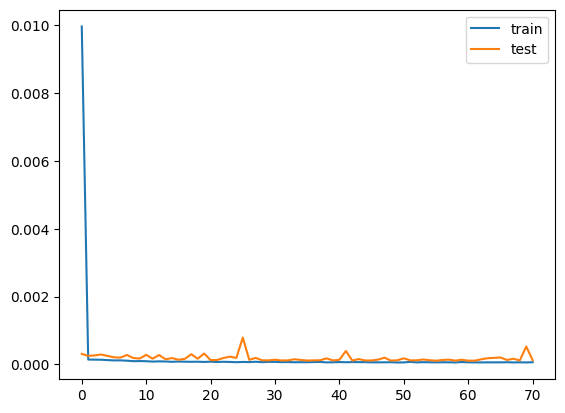

In [6]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


65/65 [==============================] - 1s 1ms/step
RMSE: 2.196291718615336
MAPE: 1.1841118217647766
MSE:  4.823697313258307
MSLE:  0.00027416347390178057
MAE:  1.6102546984052577
R-squared:  0.9835081173402799


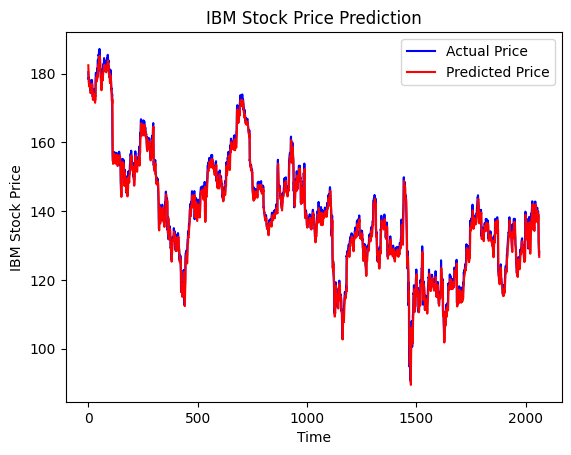

In [7]:
# Make predictions
y_pred = model.predict(X_test)

y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming y_pred and y_test are NumPy arrays
# Note: For MAPE, make sure y_test does not contain zeros to avoid division by zero.

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


print('RMSE:', rmse)
print('MAPE:', mape)


print('MSE: ', mse)
print('MSLE: ', msle)
print('MAE: ', mae)
print('R-squared: ', r2)

# Plot the predictions vs the real data
plt.plot(y_test, color='blue', label='Actual Price')
plt.plot(y_pred, color='red', label='Predicted Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()

# 1-3-9

RMSE: 9.681496370442565
MAPE: 5.433762503375542
MSE:  93.73137197089255
MSLE:  0.005184730334292754
MAE:  7.309876317143523
R-squared:  0.6795390158852281

